In [1]:
%pip install pyglet pyvirtualdisplay

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential 
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from pygame import gfxdraw
import pygame
import os
import matplotlib.pyplot as plt
os.environ['DISPLAY'] = ':0'
os.environ['GYM_DISPLAY'] = 'True'
os.environ['PYVIRTUALDISPLAY_DISPLAY'] = ':0'
os.environ['PYVIRTUALDISPLAY_SIZE'] = '1920x1080x24'
os.environ['PYVIRTUALDISPLAY_BACKEND'] = 'xvfb'
from IPython.display import clear_output

In [3]:
env = gym.make("CartPole-v1", render_mode="human")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
n_episodes = 100
output_dir = "model_output/cartpole/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.batch_size = 32
 
    def _build_model(self):
        model = Sequential() 
        model.add(Dense(32, activation="relu", input_dim=self.state_size))
        model.add(Dense(32, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=self.learning_rate))
        return model
 
    def remember(self, state, action, reward, next_state, done): 
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size) 
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def save(self, name): 
        self.model.save_weights(name)

In [5]:
agent = DQNAgent(state_size, action_size)

c:\Users\damem\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [6]:
loss = []
agent = DQNAgent(state_size, action_size)
for e in range(0, n_episodes+1):
    state = env.reset()
    state = np.reshape(state[0], (1, 4))
    score = 0
    max_steps = 1000
    for i in range(max_steps):
        env.render()
        action = agent.act(state)
        next_state, reward, done, _, info = env.step(action)
        score += reward
        next_state = np.reshape(next_state, (1, 4))
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        agent.replay()
        if done:
            print(f"{e}/{n_episodes} episodes || score: {score} || epsilon: {agent.epsilon}")
            break
        env.step(action)
    loss.append(score)
env.close()

c:\Users\damem\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\envs\classic_control\cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


0/100 episodes || score: 7.0 || epsilon: 1.0
1/100 episodes || score: 5.0 || epsilon: 1.0
2/100 episodes || score: 8.0 || epsilon: 1.0
3/100 episodes || score: 5.0 || epsilon: 1.0
4/100 episodes || score: 8.0 || epsilon: 0.9703725093562657
5/100 episodes || score: 15.0 || epsilon: 0.9000874278732445
6/100 episodes || score: 4.0 || epsilon: 0.8778091417340573
7/100 episodes || score: 8.0 || epsilon: 0.8433051360508336
8/100 episodes || score: 10.0 || epsilon: 0.8020760579717637
9/100 episodes || score: 10.0 || epsilon: 0.7590483508202912
10/100 episodes || score: 12.0 || epsilon: 0.7147372386831305
11/100 episodes || score: 8.0 || epsilon: 0.6866430931872001
12/100 episodes || score: 4.0 || epsilon: 0.6696478204705644
13/100 episodes || score: 7.0 || epsilon: 0.6465587967553006
14/100 episodes || score: 8.0 || epsilon: 0.6211445383053219
15/100 episodes || score: 14.0 || epsilon: 0.5790496471185967
16/100 episodes || score: 7.0 || epsilon: 0.5590843898207511
17/100 episodes || score: 5.

Text(0.5, 1.0, 'Cart Pole game Loss through the episodes')

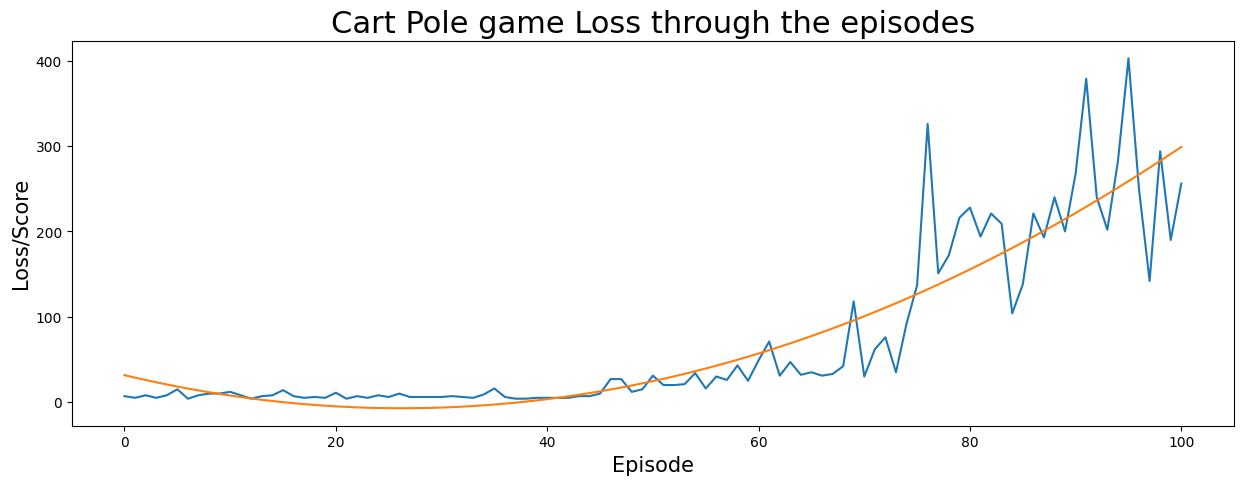

In [7]:
x = np.arange(0,n_episodes+1)
y = loss
a, b, c = np.polyfit(x, y, 2)
plt.figure(figsize=(15,5))
plt.plot(np.arange(0,n_episodes+1), loss)
plt.plot(x, a * x*x + b*x + c)
plt.xlabel('Episode', fontdict={'size' : 15})
plt.ylabel('Loss/Score', fontdict={'size' : 15})
plt.title('Cart Pole game Loss through the episodes', fontdict={'size' : 22})